In [6]:
# Import universal packages:
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.patches as mpatches 
from shapely.geometry.polygon import Polygon
import cartopy.feature as cfeature
from scipy import stats

In [25]:
filepath = '/labspaces/grace-for-global-assessment/data/inbox/GRACE'
file = 'GRCTellus.JPL.200204_202112.GLO.RL06M.MSCNv02CRI.nc'
data = os.path.join(filepath,file)
grace = xr.open_dataset(data)
grace

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, time: 204, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-12-16T1...
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2022-01-31T20:01:59Z

In [29]:
# change longitude bounds from [0:360 deg] to [-180:180 deg]

grace = grace.assign_coords(lon=(((grace.lon + 180) % 360) - 180)).sortby('lon')
grace

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, time: 204, bounds: 2)
Coordinates:
  * lon            (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-12-16T1...
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 -90.0 -89.5 -89.5 ... 89.5 89.5 90.0
    lon_bounds     (lon, bounds) float64 180.0 180.5 180.5 ... 179.5 179.5 180.0
    time_bounds    (time, bounds) datetime64[ns] 2002-04-04 ... 2021-12-31T23...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2022-01-31T20:01:59Z

In [30]:
lwe = grace.lwe_thickness

# calculate time mean 
lwe_timemean = lwe.mean(dim=['lat', 'lon'])
# calculate space mean
lwe_spacemean = lwe.mean(dim=['time'])
# select two instances for visualization
lwe_beginning = lwe.isel(time=0)
lwe_end = lwe.isel(time=-1)
# select a time slice
lwe_cut = lwe.sel(time=slice("2003-01-01", "2021-12-01"))


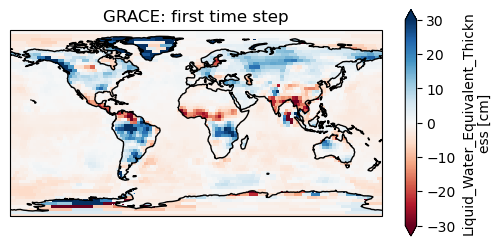

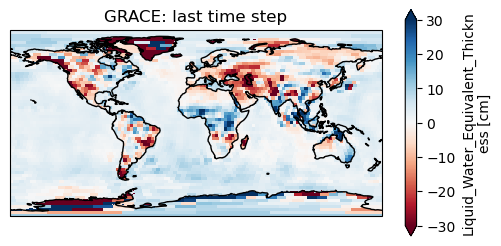

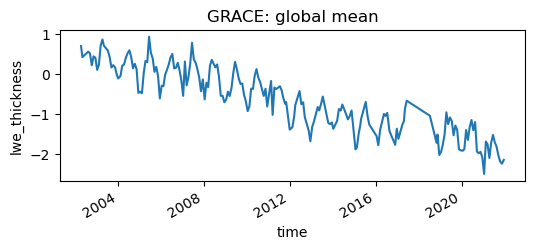

In [31]:
fig = plt.figure(figsize=(6,3), dpi=100)


ax = lwe_beginning.plot(subplot_kws=dict(projection=ccrs.PlateCarree(),facecolor="gray"),
                 transform=ccrs.PlateCarree(),
                      vmin=-30,vmax=30,
                 cmap='RdBu', label='test')

ax.axes.set_global()

ax.axes.coastlines()
plt.title('GRACE: first time step')

fig = plt.figure(figsize=(6,3), dpi=100)


ax = lwe_end.plot(subplot_kws=dict(projection=ccrs.PlateCarree(),facecolor="gray"),
                 transform=ccrs.PlateCarree(),
                      vmin=-30,vmax=30,
                 cmap='RdBu', label='test')

ax.axes.set_global()

ax.axes.coastlines()
plt.title('GRACE: last time step')



fig = plt.figure(figsize=(6,2), dpi=100)
ax = lwe_timemean.plot()
plt.title('GRACE: global mean')
plt.show()

In [35]:
# calculate trends with a linear regression (2 ways)

# FIRST OPTION: with polyfit function (1st degree polynomial)

fittingparams = lwe.polyfit(dim='time', deg=1)
trends = fittingparams.polyfit_coefficients.sel(degree=1)*(((365*14 + 366*5)/19)*24*60*60*1e9) #this gives the slope unit: cm/year 
trends.to_netcdf('/labspaces/grace-for-global-assessment/data/work/trends.nc')
# note: since time is in nanoseconds, 
# multiplying by a nanosecond in a year (considering also the leap years here) gives the following slope unit: cm/year



# SECOND OPTION: with curvefit function (defined function), slower but same results

def linear(x, slope, intercept):
    return slope*(x) + intercept

## uncomment following two lines to run:
# fittingparams = lwe.curvefit('time',linear)
# trends = fittingparams.curvefit_coefficients.sel(param='slope')*(((365*14 + 366*5)/19)*24*60*60*1e9) #this gives the slope unit: cm/year

## to check the multiplication factor:
# deltat=lwe.time.astype(int)[-1]-lwe.time.astype(int)[0]
# trends=fittingparams.curvefit_coefficients.sel(param='slope')*deltat/(number of years)

trends

<xarray.DataArray 'polyfit_coefficients' (lat: 360, lon: 720)>
array([[0.82541385, 0.82541385, 0.82541385, ..., 0.82541385, 0.82541385,
        0.82541385],
       [0.82541385, 0.82541385, 0.82541385, ..., 0.82541385, 0.82541385,
        0.82541385],
       [0.82541385, 0.82541385, 0.82541385, ..., 0.82541385, 0.82541385,
        0.82541385],
       ...,
       [0.29767395, 0.29767395, 0.29767395, ..., 0.29767395, 0.29767395,
        0.29767395],
       [0.29767395, 0.29767395, 0.29767395, ..., 0.29767395, 0.29767395,
        0.29767395],
       [0.29767395, 0.29767395, 0.29767395, ..., 0.29767395, 0.29767395,
        0.29767395]])
Coordinates:
    degree   int64 1
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8

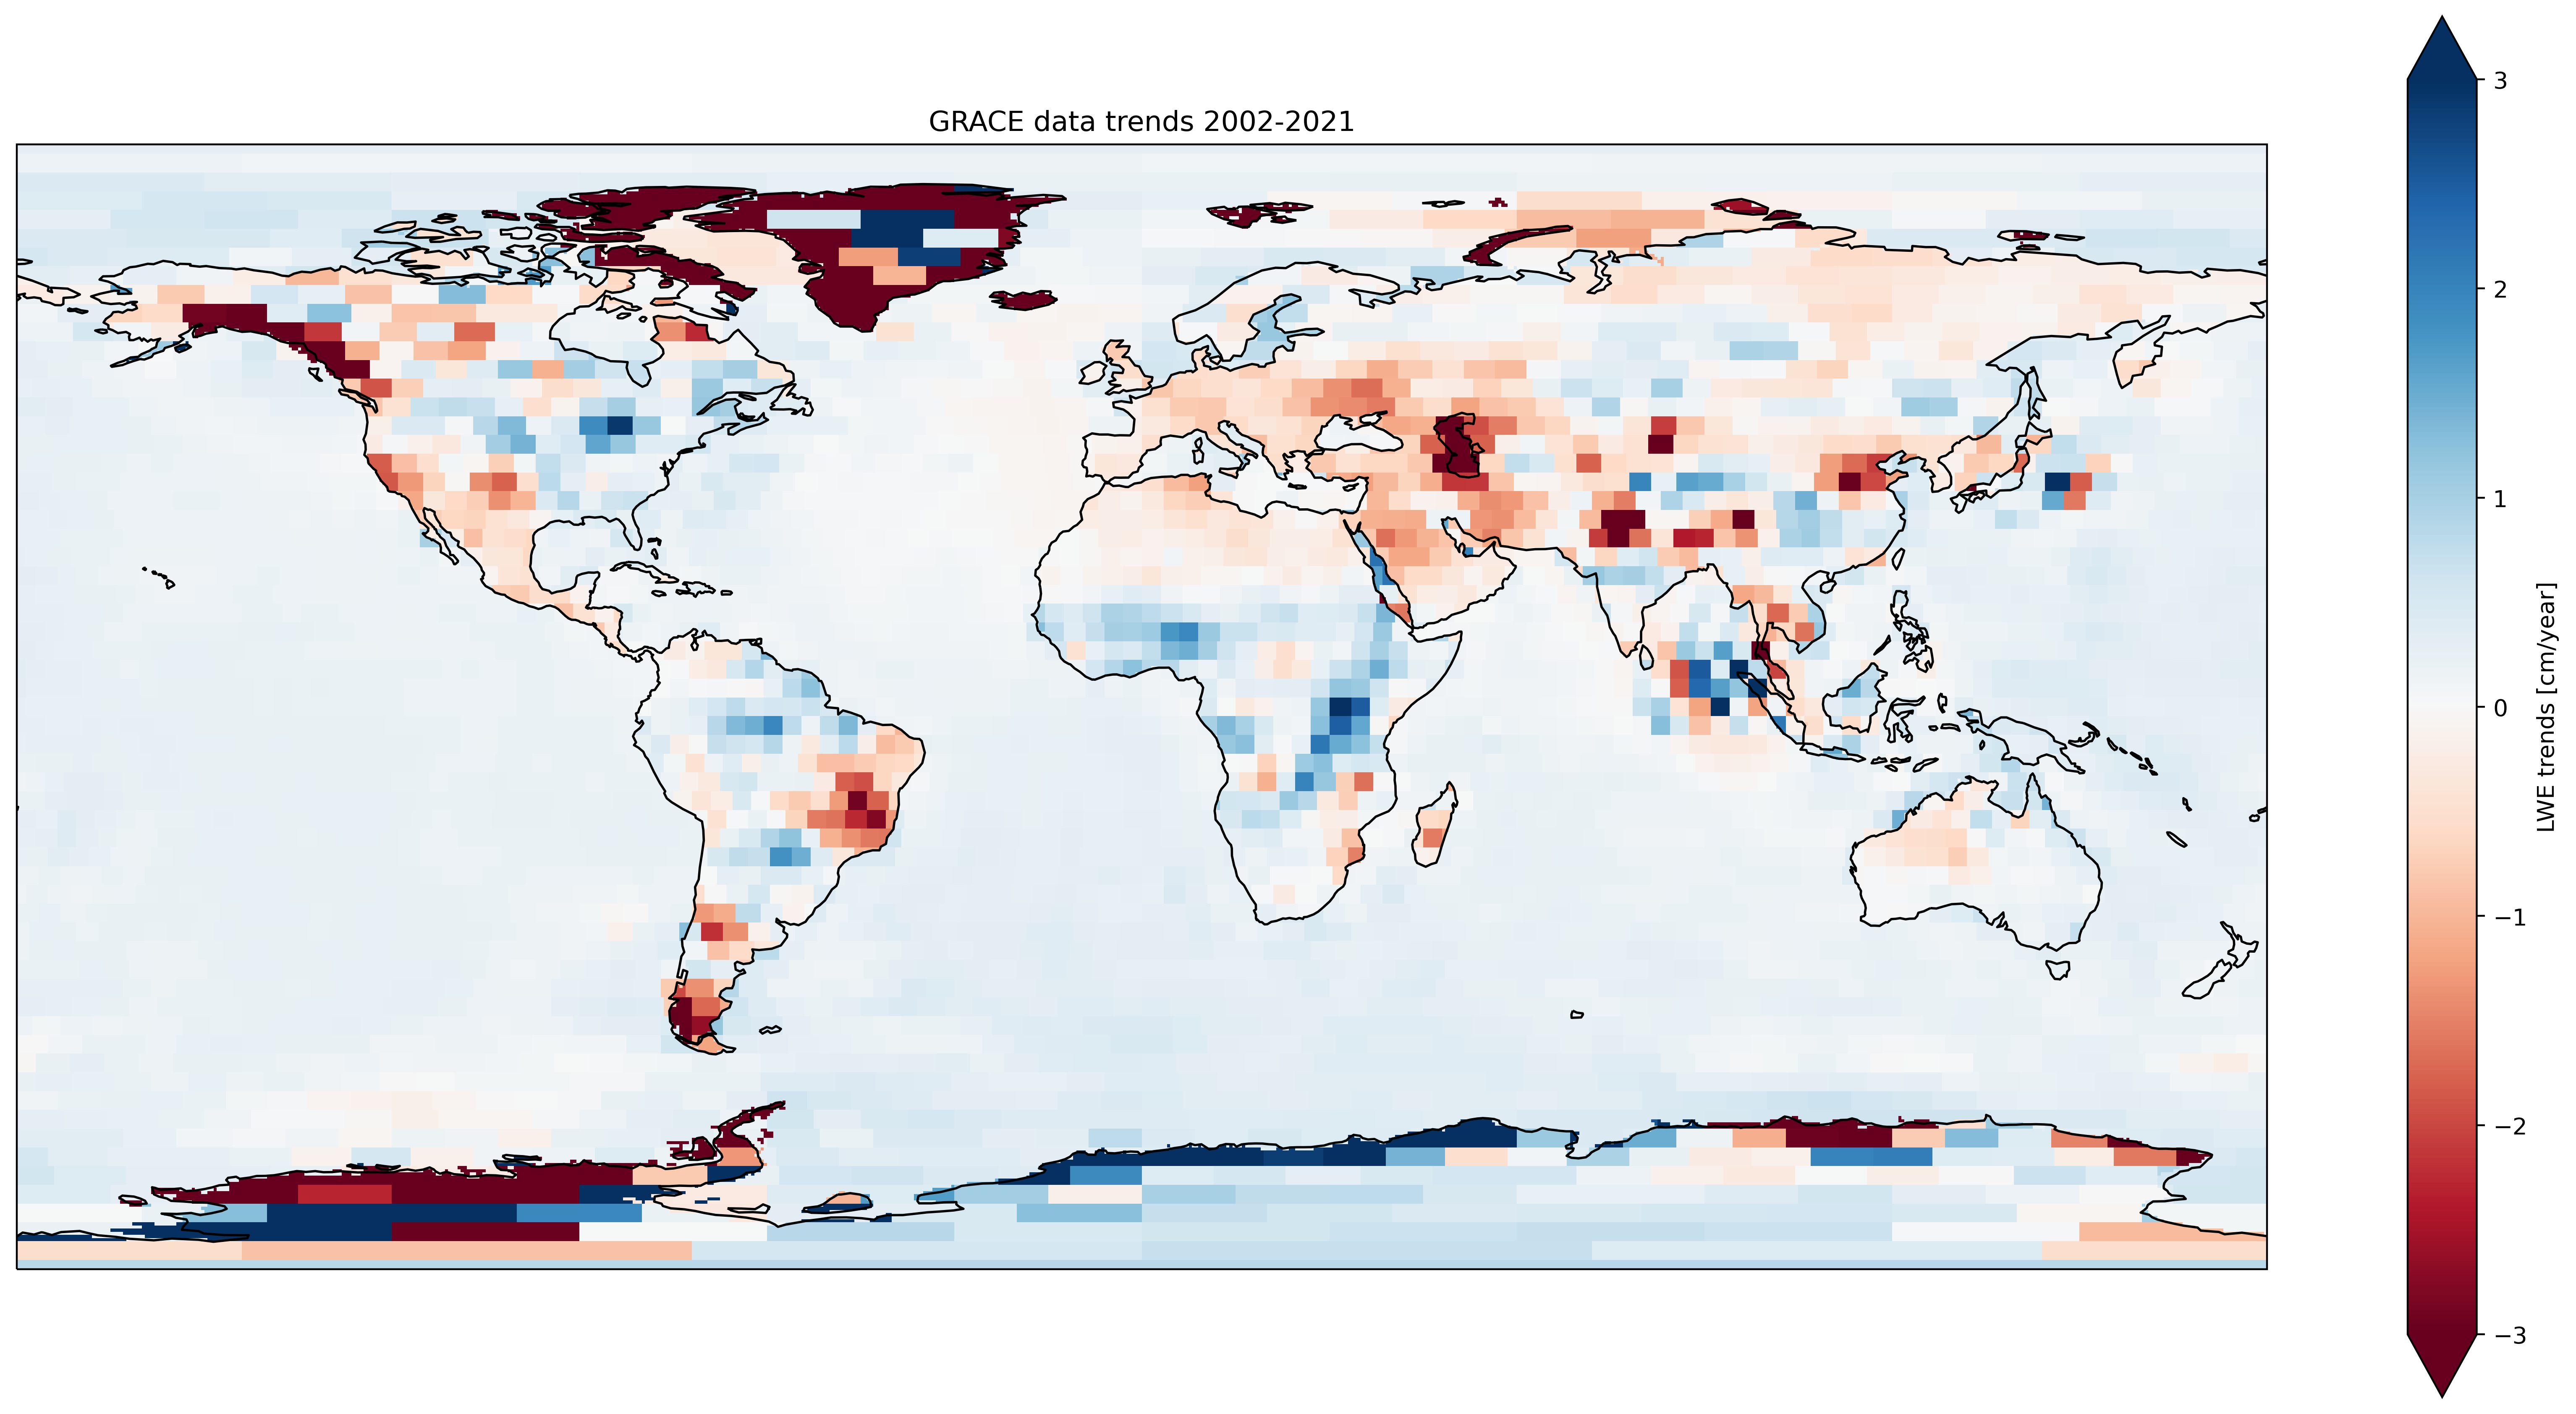

In [38]:
fig = plt.figure(figsize=(20,10), dpi=400)

#cmap=plt.cm.coolwarm,
ax = trends.plot(subplot_kws=dict(projection=ccrs.PlateCarree(),facecolor="gray"),
                 transform=ccrs.PlateCarree(),
                      vmin=-3,vmax=3,
                 cmap='RdBu', label='cm/year', cbar_kwargs={'label': 'LWE trends [cm/year]'})

ax.axes.set_global()

ax.axes.coastlines()

plt.title('GRACE data trends 2002-2021')
fig.tight_layout()
plt.savefig('/labspaces/grace-for-global-assessment/data/work/trends.png', dpi=400)